In [2]:
import arviz as az
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

import pymc as pm
print(pm.__version__)

5.15.1


In [4]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Introduction

https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview

https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html

Variable

In [5]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

In [6]:
model.basic_RVs

[mu ~ Normal(0, 1), obs ~ Normal(mu, 1)]

In [7]:
model.free_RVs


[mu ~ Normal(0, 1)]

In [8]:
model.observed_RVs

[obs ~ Normal(mu, 1)]

In [10]:
%timeit model.compile_logp()({"mu": 0.1})
logp = model.compile_logp()
%timeit logp({"mu": 0.1})

The slowest run took 7.29 times longer than the fastest. This could mean that an intermediate result is being cached.
155 ms ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.6 μs ± 3.34 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Distribution - create muti-dim

In [12]:
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}
with pm.Model(coords=coords) as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, dims="cities")

Sampling

MCMC sampling algorithm via pm.sample().  By default, this function tries to auto-assign the right sampler(s). pm.sample() returns an arviz.InferenceData object.

In [9]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(2000, chains=3, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [mu]


/opt/conda/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
idata.posterior['mu'].mean(axis=1)

<xarray.DataArray 'mu' (chain: 3)> Size: 24B
array([0.14102575, 0.14825585, 0.14137074])
Coordinates:
  * chain    (chain) int64 24B 0 1 2

Sampling results

In [13]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sd]


/opt/conda/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sd'}>, <Axes: title={'center': 'sd'}>]],
      dtype=object)

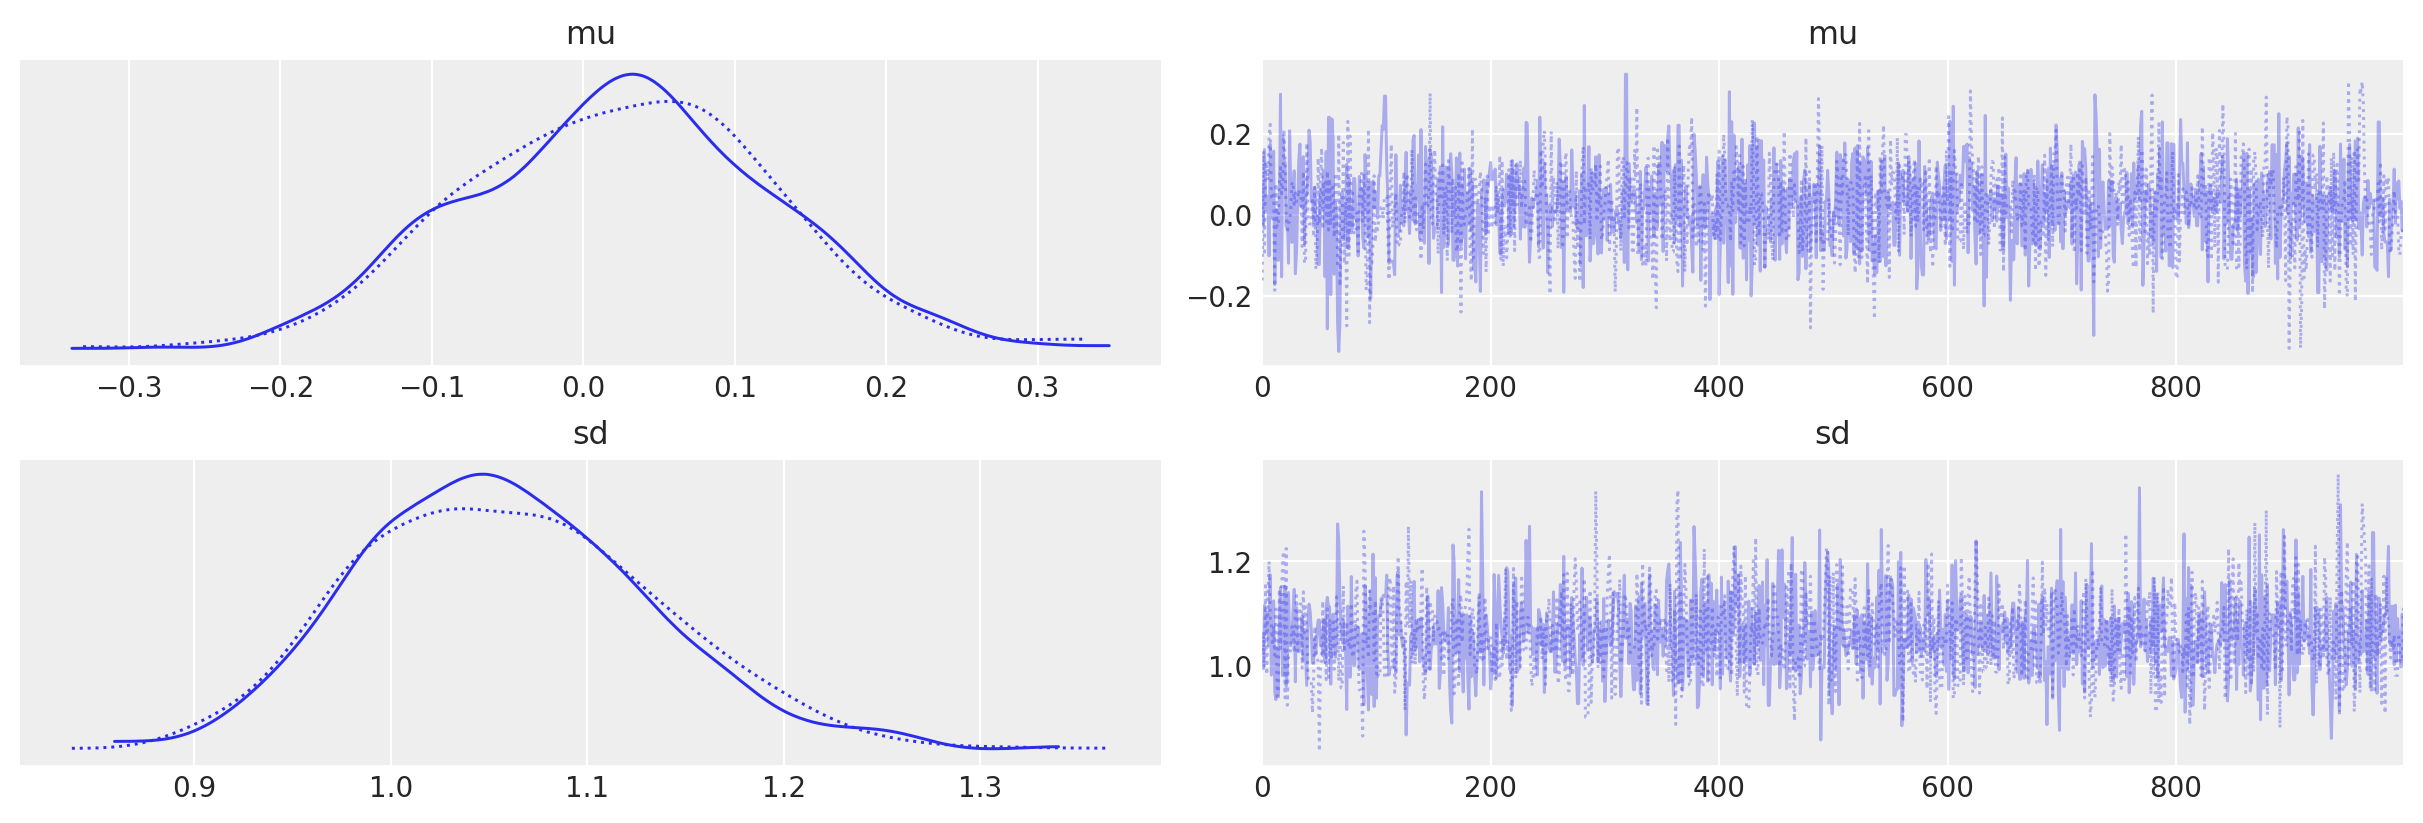

In [18]:
az.plot_trace(idata)

In [19]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.023,0.102,-0.167,0.212,0.002,0.002,1960.0,1413.0,1.0
sd,1.059,0.076,0.923,1.201,0.002,0.001,1988.0,1274.0,1.0


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sd'}>],
      dtype=object)

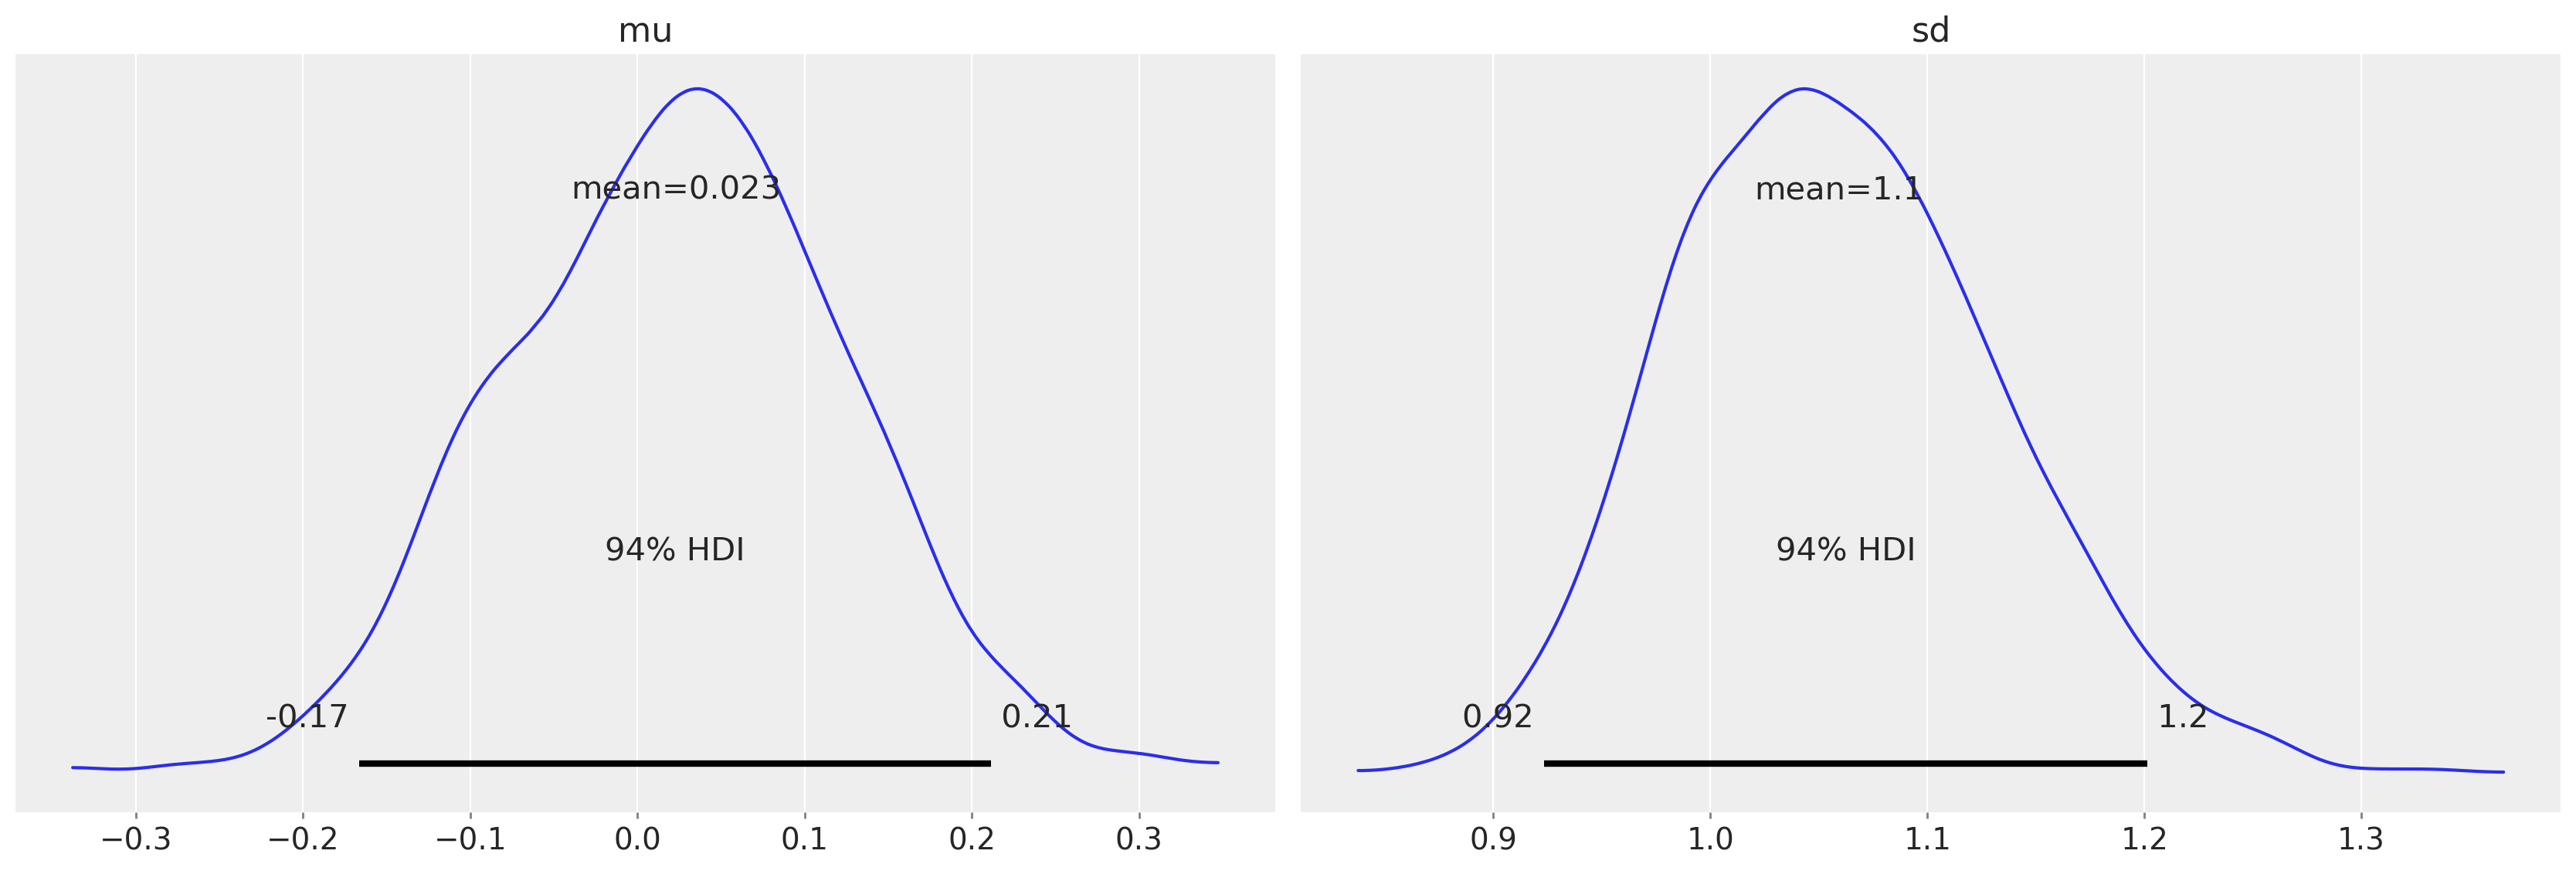

In [29]:
az.plot_posterior(idata)

prediction

In [30]:
data = rng.standard_normal(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sd]


/opt/conda/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [31]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


/opt/conda/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

# Linear Regression

$$
Y = X\beta + \epsilon \\
Y \sim N(X\beta, \sigma^2)
$$


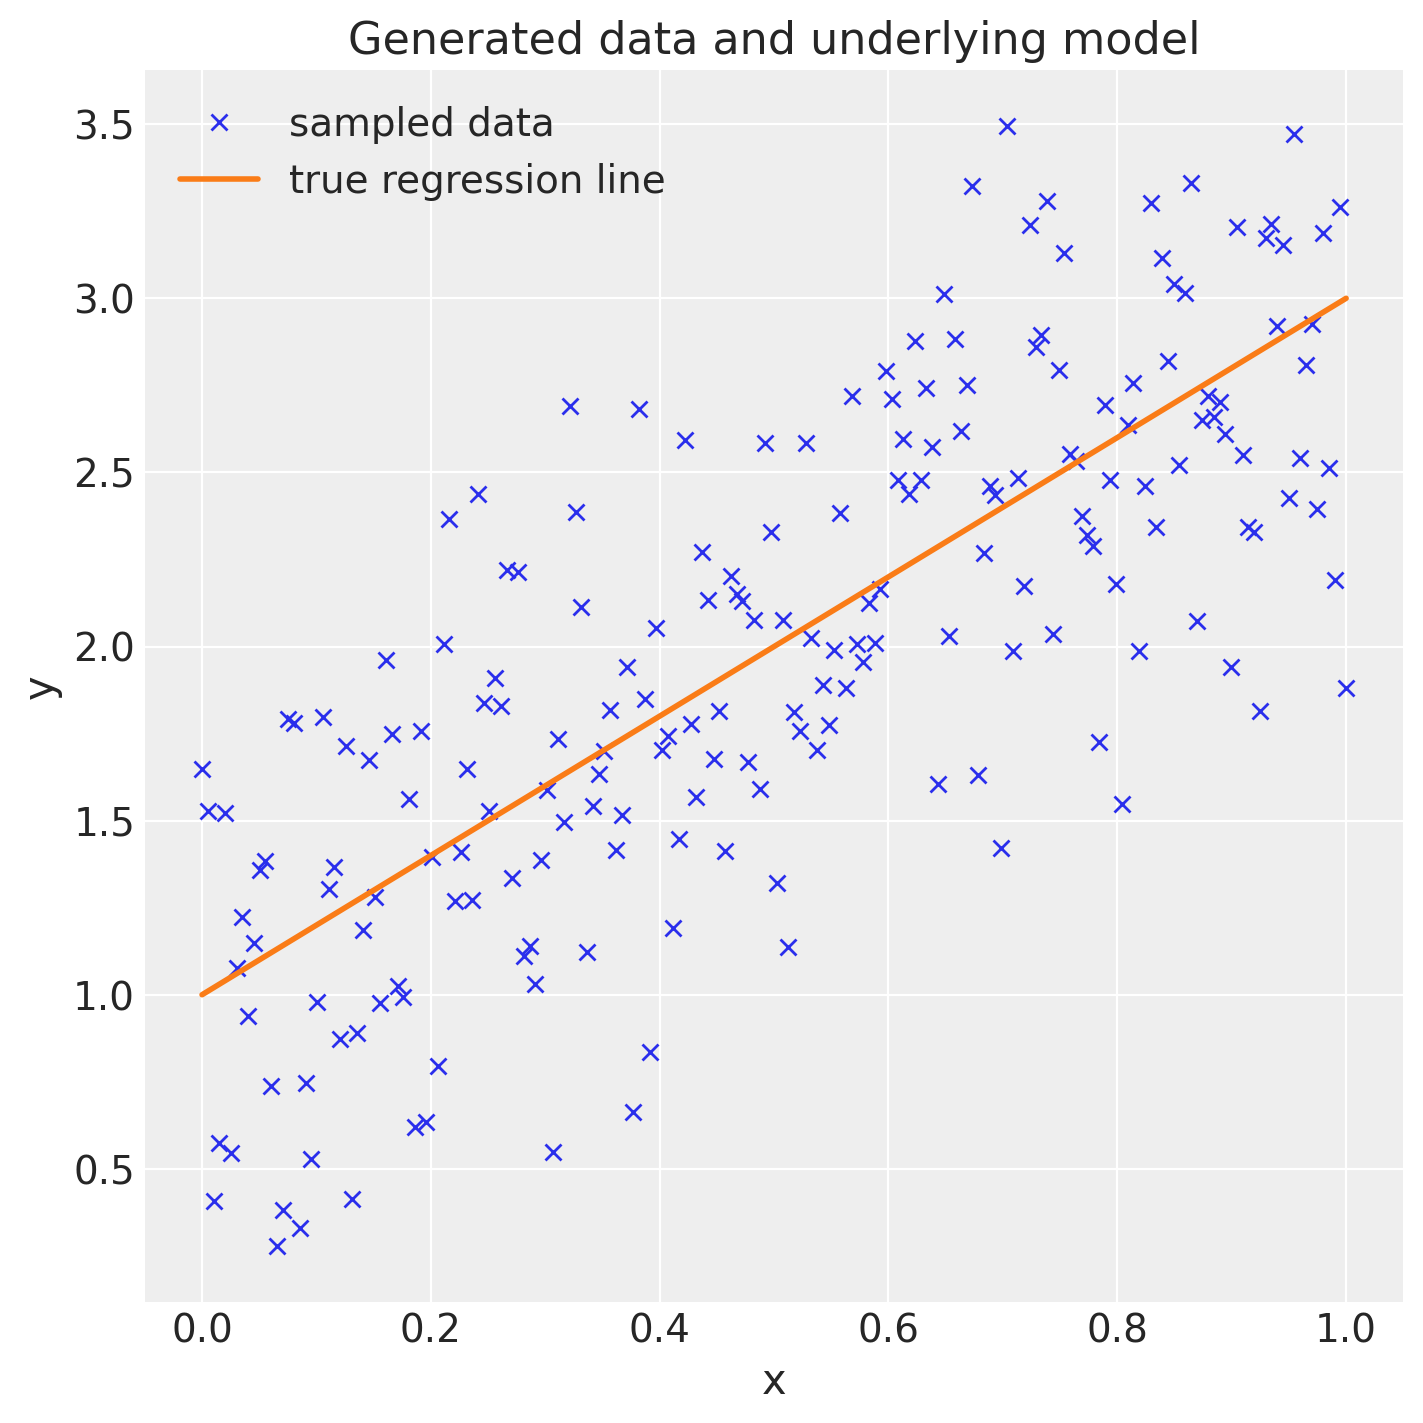

In [8]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [10]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
#     idata = pm.sample(3000)
    

# Gaussian Mixture Model

In [6]:
from scipy.stats import norm


In [7]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

(array([14., 17., 36., 32., 29., 19., 13.,  3.,  3.,  0.,  4.,  8.,  4.,
         8., 10., 11., 13., 11., 13.,  8., 16., 11., 11., 12.,  6.,  4.,
         7.,  7.,  6.,  3.,  7., 15., 10., 21., 30., 25., 21., 18.,  8.,
         6.]),
 array([-6.09103153, -5.77452297, -5.4580144 , -5.14150583, -4.82499726,
        -4.50848869, -4.19198013, -3.87547156, -3.55896299, -3.24245442,
        -2.92594585, -2.60943729, -2.29292872, -1.97642015, -1.65991158,
        -1.34340301, -1.02689445, -0.71038588, -0.39387731, -0.07736874,
         0.23913983,  0.5556484 ,  0.87215696,  1.18866553,  1.5051741 ,
         1.82168267,  2.13819124,  2.4546998 ,  2.77120837,  3.08771694,
         3.40422551,  3.72073408,  4.03724264,  4.35375121,  4.67025978,
         4.98676835,  5.30327692,  5.61978548,  5.93629405,  6.25280262,
         6.56931119]),
 <BarContainer object of 40 artists>)

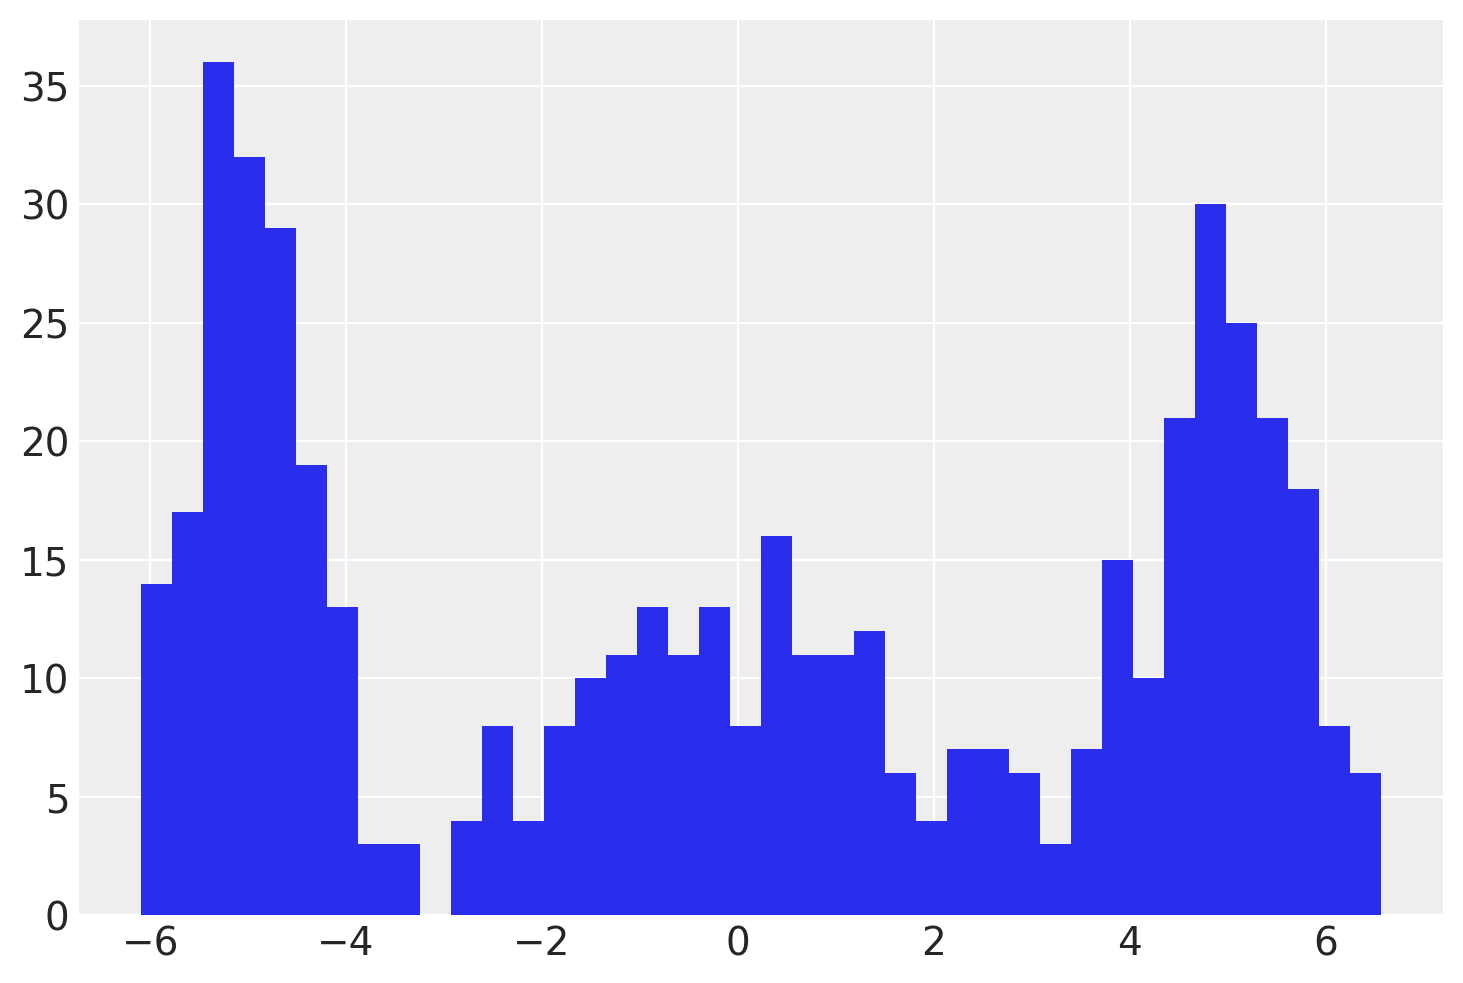

In [8]:
k = 3
ndata = 500
centers = np.array([-5, 0, 5])
sds = np.array([0.5, 2.0, 0.75])
idx = rng.integers(0, k, ndata)
x = rng.normal(loc=centers[idx], scale=sds[idx], size=ndata)
plt.hist(x, 40)

/opt/conda/envs/pymc_env/lib/python3.12/site-packages/pymc/distributions/transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)


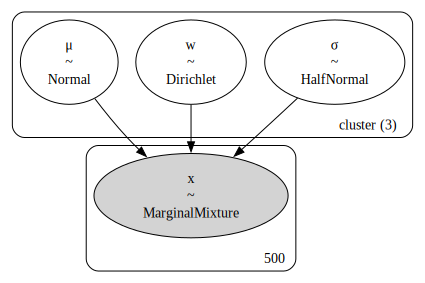

In [9]:
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal(
        "μ",
        mu=0,
        sigma=5,
        transform=pm.distributions.transforms.univariate_ordered,
        initval=[-4, 0, 4],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=x)

pm.model_to_graphviz(model)

In [10]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [μ, σ, w]


/opt/conda/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
